In [45]:
%matplotlib notebook

import os
import re
import math
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import sem
from matplotlib import colors as mcolors

In [46]:
def get_all_files_from_folder(folder, folder_name, pkl=False):
    pattern = re.compile('^{}.*'.format(folder_name))
    files = []
    pkl_files = []
    for sub_dir in os.listdir(folder):
        if pattern.fullmatch(sub_dir):
            for file in os.listdir(os.path.join(folder, sub_dir)):
                if file.endswith(".csv") and "failed" not in file:
                    files.append(os.path.join(folder, sub_dir, file))
                elif file.endswith(".pkl") and pkl:
                    pkl_files.append(os.path.join(folder, sub_dir, file))

    if pkl:
        return files, pkl_files

    return files

In [47]:
def confidence_interval(data, confidence=0.682, minus_mean=False):
    n = len(data)
    mean = np.mean(data) if minus_mean else 0
    data_sorted = sorted(data)

    lower_bound = math.floor(n * ((1 - confidence) / 2))
    upper_bound = math.floor(n * (1 - (1 - confidence) / 2))
    upper_bound = upper_bound if upper_bound < len(data) else -1

    return abs(data_sorted[lower_bound] - mean), data_sorted[upper_bound] - mean

In [48]:
def plot_style(title=None, xlabel=None, ylabel=None, **kwargs):
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.subplots_adjust(left=0.08, bottom=0.08, right=.95, top=.95)
    ax.grid(color='w', linestyle='-', linewidth=2)
    ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    for key, arg in kwargs.items():
        func = getattr(ax, f"set_{key}")
        func(arg)
    ax.patch.set_facecolor('0.95')
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

    return fig, ax

In [49]:
def combine_files(files, pkl_files):
    index_cols = [index_tuple[0] for index_tuple in list(pickle.load(open(pkl_files[0], "rb")).keys())[0]]
    dataframes = {file: pd.read_csv(file, sep=";", index_col=index_cols, float_precision='round_trip') for file in
                  files}

    for filename in pkl_files:
        df_filename = filename.replace('.pkl', '.csv')
        dataframe = dataframes[df_filename]
        data = pickle.load(open(filename, 'rb'))
        for key_value_index, sim_data in data.items():
            index = tuple(v for _, v in key_value_index)
            avg_fidelities = [(4*fid + 1)/(4 + 1) for fid in sim_data['fidelities']]
            dataframe.loc[index, 'fid_sem'] = sem(sim_data['fidelities'])
            dataframe.loc[index, 'fid_entanglement'] = sum(sim_data['fidelities']) / len(sim_data['fidelities'])
            dataframe.loc[index, 'fid_std_l'] = confidence_interval(avg_fidelities, minus_mean=True)[0]
            dataframe.loc[index, 'fid_std_r'] = confidence_interval(avg_fidelities, minus_mean=True)[1]

    return dataframes

In [50]:
def plot_non_local_cnot_fidelity(dataframes, lde_values=None, spread=False, ent_fid=False):
    fig, ax = plot_style(title="Non-local CNOT gate", xlabel="Gate error probability", ylabel="Average fidelity")
    colors = [color for key, color in mcolors.TABLEAU_COLORS.items() if key not in ['tab:orange', 'tab:red']]

    color_count = 0
    for file, df in dataframes.items():
        sample = "Purified" if "nat" not in file else "Natural abundance"
        df = df.reset_index()
        df = df.set_index('fixed_lde_attempts')
        for lde in set(df.index):
            lde_string = ("LDE attempts: " + str(lde) if all(df.loc[lde, 'pulse_duration'] > 0) else 'No decoupling')
            if lde_values is not None and lde not in lde_values and lde_string != "No decoupling":
                continue
            color_count = color_count + 1 if color_count < (len(colors) - 1) else 0
            color = colors[color_count]
            ax.errorbar(df.loc[lde, 'pg'],
                        df.loc[lde, 'avg_fidelity'],
                        yerr=None if not spread else [df.loc[lde, 'fid_std_l'], df.loc[lde, 'fid_std_r']],
                        ms=8,
                        fmt='-o',
                        capsize=8,
                        label="{} - {}".format(sample, lde_string), color=color)
            if ent_fid:
                ax.errorbar(df.loc[lde, 'pg'],
                            df.loc[lde, 'fid_entanglement'],
                            fmt='-o',
                            label="{} - {} - {}".format(sample, lde_string, "$F_{e}$"))
                ax.set_xlim(0.051, 0)

    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, prop={'size': 18})
    plt.show()

<IPython.core.display.Javascript object>


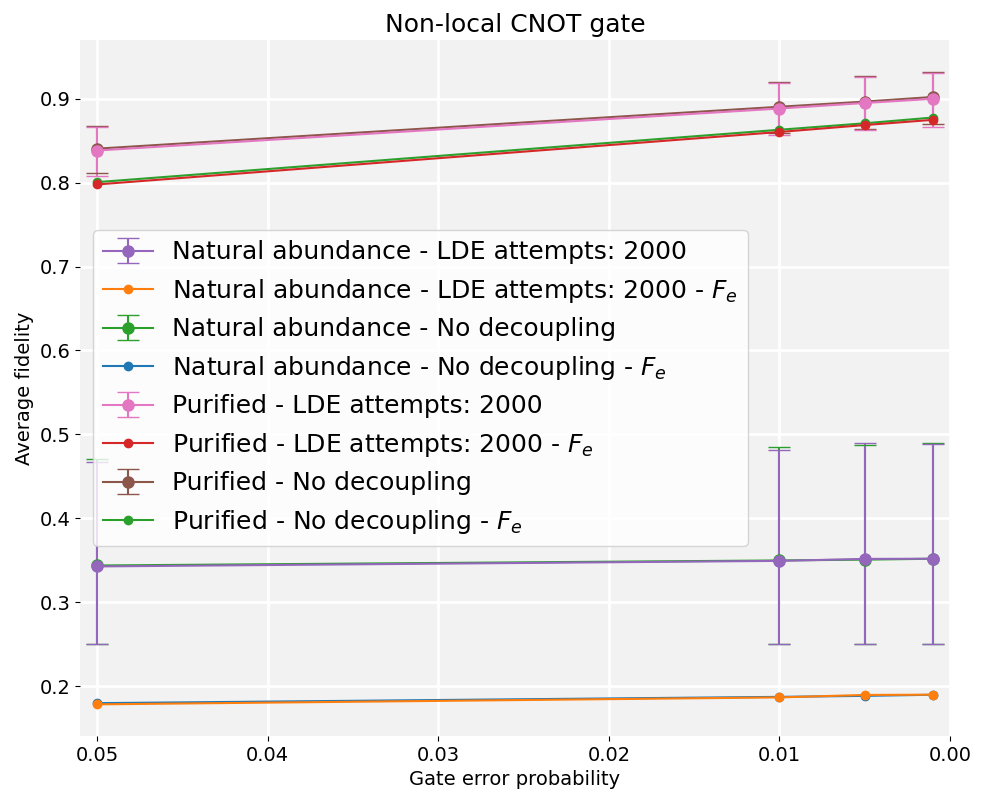

In [52]:
###### USER INPUT ########

spread = True
ent_fid = True  # Plot entanglement fidelity as well

files, pkl_files = get_all_files_from_folder("./non_local_gate", ['purified', 'natural_abundance'], True)
files = [f for f in files]
pkl_files = [p for p in pkl_files]

dataframes = combine_files(files, pkl_files)

plot_non_local_cnot_fidelity(dataframes, spread=spread, ent_fid=ent_fid)